In [4]:
from ultralytics import YOLO
import cv2
import numpy as np
from collections import defaultdict
from cap_from_youtube import cap_from_youtube
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" # to avoid OMP conficts

In [5]:
# Load an official or custom model
# model = YOLO('../models/yolov8n.pt')  # Load an official Detect model
model = YOLO('../models/yolov8x.pt')  # Load an official Detect model

# Tracking from a video file or YouTube url

In [6]:
# Open the video file
# fname="highway_drone_footage"
# fname="apollo15_10_1_1st"
# fname="cars"
# cap = cv2.VideoCapture("../videos/"+fname+".mp4")

# Open the video from YouTube
fname="from_yt_5"
# cap = cap_from_youtube("https://youtu.be/7HaJArMDKgI?si=T0Bb3zOcz-YiOnMF", '720p') # 1
# cap = cap_from_youtube("https://youtu.be/Y1jTEyb3wiI?si=-gU51avblW5Qo-ij", '720p') # 2
# cap = cap_from_youtube("https://youtu.be/jM2VrPE5kFg?si=RXfsB63fA58TuBSi", '720p') # 3
# cap = cap_from_youtube("https://youtu.be/CftLBPI1Ga4?si=N69rX1Bo3w9S6qjq", '1080p') # 4 (busy street with cars)
cap = cap_from_youtube("https://youtu.be/dDE3d6mEfn8?si=s5fAKjGVaHhfeLCQ", '2160p50') # 4 (mumbai street)


[youtube] Extracting URL: https://youtu.be/dDE3d6mEfn8?si=s5fAKjGVaHhfeLCQ
[youtube] dDE3d6mEfn8: Downloading webpage


[youtube] dDE3d6mEfn8: Downloading ios player API JSON
[youtube] dDE3d6mEfn8: Downloading m3u8 information


In [7]:
# Store the track history
track_history = defaultdict(lambda: [])

# Below VideoWriter object will create a frame of above defined The output  
# is stored in 'output.mp4' file. 
output_video = cv2.VideoWriter("../output/"+fname+"_output.mp4",  
                         cv2.VideoWriter_fourcc(*'mp4v'), # writer object # XVID
                        #  cv2.VideoWriter_fourcc(*'XVID'),
                        #  cv2.VideoWriter_fourcc('m', 'p', '4', 'v'),
                         int(cap.get(cv2.CAP_PROP_FPS)), # FPS
                         (852,480)) # frame size

# Loop through the video frames
i=0
while cap.isOpened():
    i+=1
    # Read a frame from the video
    success, frame = cap.read()

    if success:

        print(frame.shape)
        frame = cv2.resize(frame, dsize=(852,480))# reshape to 480, 852
        print(frame.shape)

        # Run YOLOv8 tracking on the frame, persisting tracks between frames
        results = model.track(frame, persist=True,tracker="bytetrack.yaml") # , show=True, stream=True

        try:
            # Get the boxes and track IDs
            boxes = results[0].boxes.xywh.cpu()
            track_ids = results[0].boxes.id.int().cpu().tolist()

            # Visualize the results on the frame
            annotated_frame = results[0].plot()

            # Plot the tracks
            for box, track_id in zip(boxes, track_ids):
                x, y, w, h = box
                track = track_history[track_id]
                track.append((float(x), float(y)))  # x, y center point
                if len(track) > 30:  # retain 90 tracks for 90 frames
                    track.pop(0)

                # Draw the tracking lines
                points = np.hstack(track).astype(np.int32).reshape((-1, 1, 2))
                cv2.polylines(annotated_frame, [points], isClosed=False, color=(255,0,0), thickness=10)

        except:
            annotated_frame = frame

        # Break the loop if 'q' is pressed
        if cv2.waitKey(1) & 0xFF == ord("q"):
            break
        
        # Display the annotated frame (requires X-forwarding ...)
        # cv2.imshow("YOLOv8 Tracking", annotated_frame)

        # write the frame to the output file
        output_video.write(annotated_frame)

        # save every n-th frame as jpg
        n=500
        if i % n == 0:
            print('saving '+str(n)+'-th frame ...')
            cv2.imwrite("../output/"+fname+"_frame_%d.jpg" % i, annotated_frame)     # save frame as JPEG file 

        # except:
        #     print("No detection in this frame, skipping ...")



        if i==80:
            print("ok, that's enough ...")
            break

        # Break the loop if 'q' is pressed
        if cv2.waitKey(1) & 0xFF == ord("q"):
            break
    else:
        print("failed to read the frame :<")
        # Break the loop if the end of the video is reached
        break

# Release the video capture object and close the display window
cap.release()
output_video.release()
cv2.destroyAllWindows()

(2160, 3840, 3)
(480, 852, 3)

0: 384x640 (no detections), 57.8ms
Speed: 2.3ms preprocess, 57.8ms inference, 18.9ms postprocess per image at shape (1, 3, 384, 640)
(2160, 3840, 3)
(480, 852, 3)

0: 384x640 (no detections), 30.1ms
Speed: 1.0ms preprocess, 30.1ms inference, 4.8ms postprocess per image at shape (1, 3, 384, 640)
(2160, 3840, 3)
(480, 852, 3)

0: 384x640 (no detections), 29.7ms
Speed: 2.3ms preprocess, 29.7ms inference, 4.8ms postprocess per image at shape (1, 3, 384, 640)
(2160, 3840, 3)
(480, 852, 3)

0: 384x640 (no detections), 29.6ms
Speed: 2.8ms preprocess, 29.6ms inference, 4.8ms postprocess per image at shape (1, 3, 384, 640)
(2160, 3840, 3)
(480, 852, 3)

0: 384x640 2 cars, 29.7ms
Speed: 1.7ms preprocess, 29.7ms inference, 53.9ms postprocess per image at shape (1, 3, 384, 640)
(2160, 3840, 3)
(480, 852, 3)

0: 384x640 10 cars, 26.6ms
Speed: 1.4ms preprocess, 26.6ms inference, 11.9ms postprocess per image at shape (1, 3, 384, 640)
(2160, 3840, 3)
(480, 852, 3)

0: 38

KeyboardInterrupt: 

# Tracking on KITTI

In [8]:
from collections import defaultdict
import cv2
import numpy as np

from ultralytics import YOLO

model = YOLO("../models/yolov8n.pt")

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("../utils/") # Adds utils python modules path.
from kitti_foundation import Kitti, Kitti_util
%matplotlib inline

v2c_filepath = '../datasets/KITTI/2011_09_26/calib_velo_to_cam.txt'
c2c_filepath = '../datasets/KITTI/2011_09_26/calib_cam_to_cam.txt'
xml_path = "../datasets/KITTI/2011_09_26/2011_09_26_drive_0005_sync/tracklet_labels.xml"

velo_path = '../datasets/KITTI/2011_09_26/2011_09_26_drive_0005_sync/velodyne_points/data'
camera_path = '../datasets/KITTI/2011_09_26/2011_09_26_drive_0005_sync/'

frame_no = 115
v_fov, h_fov = (-24.9, 2.0), (-90, 90) # field of view

In [10]:
def draw_tracklets(check):
    """ draw 3d bounding boxes around annotated objects """
    import cv2
    tracklet_, type_ = check.tracklet_info

    tracklet2d = []
    for i, j in zip(tracklet_[frame_no], type_[frame_no]):
        point = i.T
        chk,_ = check._Kitti_util__velo_2_img_projection(point)
        tracklet2d.append(chk)

    type_c = { 'Car': (0, 0, 255), 'Van': (0, 255, 0), 'Truck': (255, 0, 0), 'Pedestrian': (0,255,255), \
        'Person (sitting)': (255, 0, 255), 'Cyclist': (255, 255, 0), 'Tram': (0, 0, 0), 'Misc': (255, 255, 255)}

    line_order = ([0, 1], [1, 2],[2, 3],[3, 0], [4, 5], [5, 6], \
            [6 ,7], [7, 4], [4, 0], [5, 1], [6 ,2], [7, 3])

    for i, j in zip(tracklet2d, type_[frame_no]):
        for k in line_order:    
            cv2.line(image, (int(i[0][k[0]]), int(i[1][k[0]])), (int(i[0][k[1]]), int(i[1][k[1]])), type_c[j], 2)
        cv2.putText(image, j, (int(i[0][k[0]]), int(-10+i[1][k[0]])), cv2.FONT_HERSHEY_PLAIN, 1, type_c[j], 2)

Just using a regular camera image

In [11]:
# read left camera image
with_tracklets = True
image_type = 'color'  # 'gray' or 'color' image
mode = '00' if image_type == 'gray' else '02'  # image_00 = 'gray image' , image_02 = 'color image'

image_path = camera_path+'image_' + mode + '/data'
check = Kitti_util(frame=frame_no, velo_path=velo_path, camera_path=image_path, \
                   xml_path=xml_path, v2c_path=v2c_filepath, c2c_path=c2c_filepath)
image = check.camera_file

results = model.track(source=image, persist=True,tracker="bytetrack.yaml")

txt=""
if with_tracklets:
    draw_tracklets(check)
    txt="_with_tracklets"

for result in results:
    result.save(filename="../output/result_only_camera_frame_"+str(frame_no)+""+txt+".jpg")  # save to disk


parsing tracklet file ../datasets/KITTI/2011_09_26/2011_09_26_drive_0005_sync/tracklet_labels.xml
file contains 15 tracklets
loaded 15 tracklets

0: 224x640 4 cars, 47.3ms
Speed: 0.7ms preprocess, 47.3ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)


In [12]:
image[:,:,0].shape

(375, 1242)

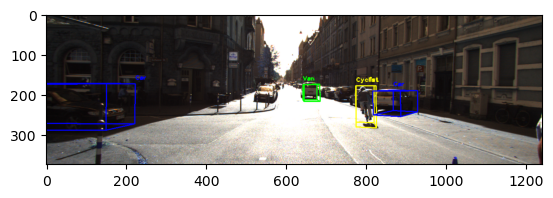

In [13]:
plt.imshow(image)

In [14]:
# results "cheat sheet":
# # Process results list
# for result in results:
#     boxes = result.boxes  # Boxes object for bounding box outputs
#     masks = result.masks  # Masks object for segmentation masks outputs
#     keypoints = result.keypoints  # Keypoints object for pose outputs
#     probs = result.probs  # Probs object for classification outputs
#     obb = result.obb  # Oriented boxes object for OBB outputs
#     result.show()  # display to screen
#     result.save(filename="result.jpg")  # save to disk

Using a camera image with projected lidar data

In [15]:
def print_projection_plt(points, color, image, velo_only=False):
    """ project converted velodyne points into camera image """
    if velo_only:
        hsv_image=image*0
    else:
        hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    for i in range(points.shape[1]):
        cv2.circle(hsv_image, (np.int32(points[0][i]),np.int32(points[1][i])),1, (int(color[i]),255,255),-1)

    return cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)

In [18]:
# v2c_filepath = '../datasets/KITTI/training/calib/0000.txt'
# c2c_filepath = '../datasets/KITTI/training/calib/0000.txt'

# velo_path = '../datasets/KITTI/training/velodyne/0000'
# camera_path = '../datasets/KITTI/training/image_02/0000'

In [2]:
def read_calib_file(filepath):
    """Read in a calibration file and parse into a dictionary."""
    import numpy as np
    
    data = {}

    with open(filepath, 'r') as f:
        for line in f.readlines():
            try:
                key, value = line.split(':', 1)
            except ValueError:
                key, value = line.split(' ', 1)
            # The only non-float values in these files are dates, which
            # we don't care about anyway
            try:
                data[key] = np.array([float(x) for x in value.split()])
            except ValueError:
                pass

    return data

In [3]:
import pandas as pd
df = pd.read_csv('../datasets/KITTI/training/calib/0000.txt',sep=' ',index_col=0,usecols=range(13)).transpose()
# df['index']=range(12)
# df.reset_index()

In [4]:
df

P0:,P1:,P2:,P3:,R_rect,Tr_velo_cam,Tr_imu_velo
7.215377000000e+02,721.5377,721.537700,721.537700,0.999924,0.007534,0.999998
0.000000000000e+00,0.0000,0.000000,0.000000,0.009838,-0.999971,0.000755
6.095593000000e+02,609.5593,609.559300,609.559300,-0.007445,-0.000617,-0.002036
0.000000000000e+00.1,-387.5744,44.857280,-339.524200,-0.009870,-0.004070,-0.808676
0.000000000000e+00.2,0.0000,0.000000,0.000000,0.999942,0.014802,-0.000785
7.215377000000e+02.1,721.5377,721.537700,721.537700,-0.004278,0.000728,0.999890
1.728540000000e+02,172.8540,172.854000,172.854000,0.007403,-0.999890,-0.014823
0.000000000000e+00.3,0.0000,0.216379,2.199936,0.004352,-0.076316,0.319556
0.000000000000e+00.4,0.0000,0.000000,0.000000,0.999963,0.999862,0.002024
0.000000000000e+00.5,0.0000,0.000000,0.000000,NaN,0.007524,0.014825


In [5]:
df.keys()

Index(['P1:', 'P2:', 'P3:', 'R_rect', 'Tr_velo_cam', 'Tr_imu_velo'], dtype='object', name='P0:')

In [6]:
filedata = read_calib_file('../datasets/KITTI/training/calib/0000.txt')

In [7]:
filedata

{'P0': array([721.5377,   0.    , 609.5593,   0.    ,   0.    , 721.5377,
        172.854 ,   0.    ,   0.    ,   0.    ,   1.    ,   0.    ]),
 'P1': array([ 721.5377,    0.    ,  609.5593, -387.5744,    0.    ,  721.5377,
         172.854 ,    0.    ,    0.    ,    0.    ,    1.    ,    0.    ]),
 'P2': array([7.215377e+02, 0.000000e+00, 6.095593e+02, 4.485728e+01,
        0.000000e+00, 7.215377e+02, 1.728540e+02, 2.163791e-01,
        0.000000e+00, 0.000000e+00, 1.000000e+00, 2.745884e-03]),
 'P3': array([ 7.215377e+02,  0.000000e+00,  6.095593e+02, -3.395242e+02,
         0.000000e+00,  7.215377e+02,  1.728540e+02,  2.199936e+00,
         0.000000e+00,  0.000000e+00,  1.000000e+00,  2.729905e-03]),
 'R_rect': array([ 0.9999239 ,  0.00983776, -0.00744505, -0.0098698 ,  0.9999421 ,
        -0.00427846,  0.00740253,  0.00435161,  0.9999631 ]),
 'Tr_velo_cam': array([ 7.533745e-03, -9.999714e-01, -6.166020e-04, -4.069766e-03,
         1.480249e-02,  7.280733e-04, -9.998902e-01, -7.6316

In [31]:
filedata['R_rect']

array([ 0.9999239 ,  0.00983776, -0.00744505, -0.0098698 ,  0.9999421 ,
       -0.00427846,  0.00740253,  0.00435161,  0.9999631 ])

In [14]:
import numpy as np

data = {}

# Create 3x4 projection matrices
P_rect_00 = np.reshape(filedata['P0'], (3, 4))
P_rect_10 = np.reshape(filedata['P1'], (3, 4))
P_rect_20 = np.reshape(filedata['P2'], (3, 4))
P_rect_30 = np.reshape(filedata['P3'], (3, 4))

data['P_rect_00'] = P_rect_00
data['P_rect_10'] = P_rect_10
data['P_rect_20'] = P_rect_20
data['P_rect_30'] = P_rect_30

# Compute the rectified extrinsics from cam0 to camN
T1 = np.eye(4)
T1[0, 3] = P_rect_10[0, 3] / P_rect_10[0, 0]
T2 = np.eye(4)
T2[0, 3] = P_rect_20[0, 3] / P_rect_20[0, 0]
T3 = np.eye(4)
T3[0, 3] = P_rect_30[0, 3] / P_rect_30[0, 0]

# Compute the velodyne to rectified camera coordinate transforms
data['T_cam0_velo'] = np.reshape(filedata['Tr_velo_cam'], (3, 4))
data['T_cam0_velo'] = np.vstack([data['T_cam0_velo'], [0, 0, 0, 1]])
data['T_cam1_velo'] = T1.dot(data['T_cam0_velo'])
data['T_cam2_velo'] = T2.dot(data['T_cam0_velo'])
data['T_cam3_velo'] = T3.dot(data['T_cam0_velo'])

# Compute the camera intrinsics
data['K_cam0'] = P_rect_00[0:3, 0:3]
data['K_cam1'] = P_rect_10[0:3, 0:3]
data['K_cam2'] = P_rect_20[0:3, 0:3]
data['K_cam3'] = P_rect_30[0:3, 0:3]

# Compute the stereo baselines in meters by projecting the origin of
# each camera frame into the velodyne frame and computing the distances
# between them
p_cam = np.array([0, 0, 0, 1])
p_velo0 = np.linalg.inv(data['T_cam0_velo']).dot(p_cam)
p_velo1 = np.linalg.inv(data['T_cam1_velo']).dot(p_cam)
p_velo2 = np.linalg.inv(data['T_cam2_velo']).dot(p_cam)
p_velo3 = np.linalg.inv(data['T_cam3_velo']).dot(p_cam)

data['b_gray'] = np.linalg.norm(p_velo1 - p_velo0)  # gray baseline
data['b_rgb'] = np.linalg.norm(p_velo3 - p_velo2)   # rgb baseline

In [30]:
data['T_cam0_velo']

array([[ 7.533745e-03, -9.999714e-01, -6.166020e-04, -4.069766e-03],
       [ 1.480249e-02,  7.280733e-04, -9.998902e-01, -7.631618e-02],
       [ 9.998621e-01,  7.523790e-03,  1.480755e-02, -2.717806e-01],
       [ 0.000000e+00,  0.000000e+00,  0.000000e+00,  1.000000e+00]])

In [ ]:
np.matmul(data['K_cam2'],np.matmul(data['P_rect_20'],np.matmul(,data['T_cam0_velo'])))

In [28]:
a = np.array([[1, 0],
              [0, -1]])
b = np.array([[4, 1],
              [2, 2]])
np.matmul(a, b)

array([[ 4,  1],
       [-2, -2]])

In [ ]:
def _load_calib(self):
    """Load and compute intrinsic and extrinsic calibration parameters."""
    # We'll build the calibration parameters as a dictionary, then
    # convert it to a namedtuple to prevent it from being modified later
    data = {}

    # Load the calibration file
    # calib_filepath = os.path.join(self.sequence_path + '.txt', 'calib.txt')
    calib_filepath = os.path.join(self.base_path, 'calib', self.sequence + '.txt')
    filedata = utils.read_calib_file(calib_filepath)

    # Create 3x4 projection matrices
    P_rect_00 = np.reshape(filedata['P0'], (3, 4))
    P_rect_10 = np.reshape(filedata['P1'], (3, 4))
    P_rect_20 = np.reshape(filedata['P2'], (3, 4))
    P_rect_30 = np.reshape(filedata['P3'], (3, 4))

    data['P_rect_00'] = P_rect_00
    data['P_rect_10'] = P_rect_10
    data['P_rect_20'] = P_rect_20
    data['P_rect_30'] = P_rect_30

    # Compute the rectified extrinsics from cam0 to camN
    T1 = np.eye(4)
    T1[0, 3] = P_rect_10[0, 3] / P_rect_10[0, 0]
    T2 = np.eye(4)
    T2[0, 3] = P_rect_20[0, 3] / P_rect_20[0, 0]
    T3 = np.eye(4)
    T3[0, 3] = P_rect_30[0, 3] / P_rect_30[0, 0]

    # Compute the velodyne to rectified camera coordinate transforms
    data['T_cam0_velo'] = np.reshape(filedata['Tr_velo_cam'], (3, 4))
    data['T_cam0_velo'] = np.vstack([data['T_cam0_velo'], [0, 0, 0, 1]])
    data['T_cam1_velo'] = T1.dot(data['T_cam0_velo'])
    data['T_cam2_velo'] = T2.dot(data['T_cam0_velo'])
    data['T_cam3_velo'] = T3.dot(data['T_cam0_velo'])

    # Compute the camera intrinsics
    data['K_cam0'] = P_rect_00[0:3, 0:3]
    data['K_cam1'] = P_rect_10[0:3, 0:3]
    data['K_cam2'] = P_rect_20[0:3, 0:3]
    data['K_cam3'] = P_rect_30[0:3, 0:3]

    # Compute the stereo baselines in meters by projecting the origin of
    # each camera frame into the velodyne frame and computing the distances
    # between them
    p_cam = np.array([0, 0, 0, 1])
    p_velo0 = np.linalg.inv(data['T_cam0_velo']).dot(p_cam)
    p_velo1 = np.linalg.inv(data['T_cam1_velo']).dot(p_cam)
    p_velo2 = np.linalg.inv(data['T_cam2_velo']).dot(p_cam)
    p_velo3 = np.linalg.inv(data['T_cam3_velo']).dot(p_cam)

    data['b_gray'] = np.linalg.norm(p_velo1 - p_velo0)  # gray baseline
    data['b_rgb'] = np.linalg.norm(p_velo3 - p_velo2)   # rgb baseline

    self.calib = namedtuple('CalibData', data.keys())(*data.values())

In [ ]:
T^{cam2}_{velo} = P^{cam2}_{rect2} R^{rect2}_{ref2} T^{ref2}_{ref0} T^{ref0}_{velo}

In [19]:
image_type = 'gray'  # 'gray' or 'color' image
mode = '00' if image_type == 'gray' else '02'  # image_00 = 'gray image' , image_02 = 'color image'

image_path = camera_path+'image_' + mode + '/data'
res = Kitti_util(frame=frame_no, camera_path=image_path, velo_path=velo_path, \
                v2c_path=v2c_filepath, c2c_path=c2c_filepath)

img, pnt, c_ = res.velo_projection_frame(v_fov=v_fov, h_fov=h_fov)

image = print_projection_plt(pnt, c_, img, velo_only=True) # img*0 

results = model.track(source=image, persist=True,tracker="bytetrack.yaml")

txt=""

for result in results:
    result.save(filename="../output/result_camera_with_lidar_proj_frame_"+str(frame_no)+""+txt+".jpg")  # save to disk


ValueError: not enough values to unpack (expected 2, got 1)

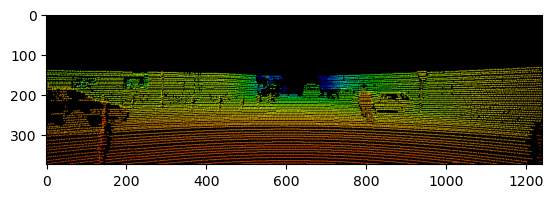

In [17]:
plt.imshow(image)

In [29]:
res.velo_file.shape

(121649, 3)

In [23]:
# Load the YOLOv8 model
model = YOLO("yolov8n.pt")

txt=""
image_type = 'gray'  # 'gray' or 'color' image
mode = '00' if image_type == 'gray' else '02'  # image_00 = 'gray image' , image_02 = 'color image'
image_path = camera_path+'image_' + mode + '/data'

In [24]:
image.shape[:2]

(375, 1242)

In [25]:
# Store the track history
track_history = defaultdict(lambda: [])

# Below VideoWriter object will create a frame of above defined The output  
# is stored in 'output.mp4' file. 
output_video = cv2.VideoWriter("../output/kitti_test_output.mp4",  
                         cv2.VideoWriter_fourcc(*'mp4v'), # writer object # XVID or mp4v
                        #  cv2.VideoWriter_fourcc(*'XVID'),
                        #  cv2.VideoWriter_fourcc('m', 'p', '4', 'v'),
                         10, # FPS
                         image.shape[:2]) # frame size

for frame_no in range(1,20):

    # read the next KITTI frame:
    img, pnt, c_ = Kitti_util(
        frame=frame_no, camera_path=image_path, velo_path=velo_path, v2c_path=v2c_filepath, c2c_path=c2c_filepath
    ).velo_projection_frame(v_fov=v_fov, h_fov=h_fov)
    frame = print_projection_plt(pnt, c_, img, velo_only=True)

    # print(frame.shape)
    cv2.resize(frame, dsize=image.shape[:2]) # reshape to 480, 852
    # print(frame.shape)

    # do the object detection for tracking:
    results = model.track(
        source=frame, 
        persist=True,tracker="bytetrack.yaml"
    )

    try: # will work ONLY if there was some detection!
        # Get the boxes and track IDs
        boxes = results[0].boxes.xywh.cpu()
        track_ids = results[0].boxes.id.int().cpu().tolist()

        # Visualize the results on the frame
        annotated_frame = results[0].plot()

        # Plot the tracks
        for box, track_id in zip(boxes, track_ids):
            x, y, w, h = box
            track = track_history[track_id]
            track.append((float(x), float(y)))  # x, y center point
            if len(track) > 30:  # retain 90 tracks for 90 frames
                track.pop(0)

            # Draw the tracking lines
            points = np.hstack(track).astype(np.int32).reshape((-1, 1, 2))
            cv2.polylines(annotated_frame, [points], isClosed=False, color=(0,0,255), thickness=10)
    except:
        annotated_frame = frame

    if frame_no % 5 == 0:
        cv2.imwrite("../output/KITTI_frame_%d.jpg" % frame_no, annotated_frame)     # save frame as JPEG file

    # write the frame to the output file
    output_video.write(annotated_frame)

    # Display the annotated frame
    # cv2.imshow("YOLOv8 Tracking", annotated_frame)


output_video.release()
cv2.destroyAllWindows()

(375, 1242, 3)
(375, 1242, 3)

0: 224x640 4 persons, 2.7ms
Speed: 0.7ms preprocess, 2.7ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)
(375, 1242, 3)
(375, 1242, 3)

0: 224x640 7 persons, 2.4ms
Speed: 0.5ms preprocess, 2.4ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 640)
(375, 1242, 3)
(375, 1242, 3)

0: 224x640 3 persons, 4.0ms
Speed: 1.2ms preprocess, 4.0ms inference, 12.0ms postprocess per image at shape (1, 3, 224, 640)
(375, 1242, 3)
(375, 1242, 3)

0: 224x640 3 persons, 12.3ms
Speed: 1.0ms preprocess, 12.3ms inference, 13.6ms postprocess per image at shape (1, 3, 224, 640)
(375, 1242, 3)
(375, 1242, 3)

0: 224x640 1 person, 9.3ms
Speed: 1.8ms preprocess, 9.3ms inference, 13.3ms postprocess per image at shape (1, 3, 224, 640)
(375, 1242, 3)
(375, 1242, 3)

0: 224x640 1 person, 12.2ms
Speed: 2.3ms preprocess, 12.2ms inference, 13.2ms postprocess per image at shape (1, 3, 224, 640)
(375, 1242, 3)
(375, 1242, 3)

0: 224x640 1 person, 8.3ms
Speed:

In [35]:
output_video.release()

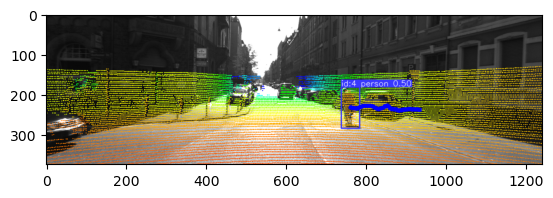

In [33]:
plt.imshow(annotated_frame)

# Try training on lidar-only data

In [1]:
%env WANDB_DISABLED=True

env: WANDB_DISABLED=True


In [2]:
from ultralytics import YOLO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import shutil
from PIL import Image

In [3]:
base_dir = Path('/kaggle/input/kitti-dataset')
img_path = base_dir / 'data_object_image_2' / 'training' / 'image_2'
label_path = Path('/kaggle/input/kitti-dataset-yolo-format/labels')
with open('/kaggle/input/kitti-dataset-yolo-format/classes.json','r') as f:
    classes = json.load(f)

classes = 

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/kitti-dataset-yolo-format/classes.json'

New https://pypi.org/project/ultralytics/8.2.38 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.31 🚀 Python-3.12.3 torch-2.3.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3090, 24253MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=coco8.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_fr

train: Scanning /home/piokal/automotive-tracking/examples/datasets/coco8/labels/train.cache... 4 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4/4 [00:00<?, ?it/s]
val: Scanning /home/piokal/automotive-tracking/examples/datasets/coco8/labels/val.cache... 4 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4/4 [00:00<?, ?it/s]


Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000119, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train3
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100     0.835G      2.956      5.999      2.734         21        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]

                   all          4         17     0.0171     0.0167    0.00311    0.00119

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      2/100      0.83G      2.672      5.187      2.646         36        640: 100%|██████████| 1/1 [00:00<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 28.69it/s]

                   all          4         17   0.000437       0.05   0.000957   0.000195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      0.83G      2.663      5.736      2.504         20        640: 100%|██████████| 1/1 [00:00<00:00, 21.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 31.70it/s]

                   all          4         17   0.000432       0.05   0.000942   0.000294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100     0.833G      3.113      5.602      2.728         21        640: 100%|██████████| 1/1 [00:00<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.92it/s]

                   all          4         17   0.000574     0.0667   0.000993   0.000239

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      5/100     0.828G       3.43      5.883      2.914         19        640: 100%|██████████| 1/1 [00:00<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.86it/s]

                   all          4         17   0.000288     0.0333   0.000402   8.03e-05

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      6/100     0.854G      2.448       5.57      2.376         22        640: 100%|██████████| 1/1 [00:00<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.86it/s]

                   all          4         17   0.000143     0.0167   0.000193   1.93e-05

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      7/100     0.858G      3.266      6.045      2.974         20        640: 100%|██████████| 1/1 [00:00<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]

                   all          4         17   0.000139     0.0167   0.000225   2.25e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100     0.854G      3.283      5.818      3.109         20        640: 100%|██████████| 1/1 [00:00<00:00, 18.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 30.41it/s]

                   all          4         17   0.000139     0.0167   0.000122   1.22e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100     0.851G      2.989      5.973      2.791         20        640: 100%|██████████| 1/1 [00:00<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.99it/s]

                   all          4         17   0.000139     0.0167   9.27e-05   9.27e-06

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     10/100     0.854G      2.788      5.334      2.644         25        640: 100%|██████████| 1/1 [00:00<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.91it/s]

                   all          4         17   0.000278     0.0333    0.00022    2.2e-05

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     11/100     0.854G      2.608      5.368      2.646         31        640: 100%|██████████| 1/1 [00:00<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.83it/s]

                   all          4         17   0.000139     0.0167   8.52e-05   8.52e-06

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     12/100     0.854G      2.305      5.381      2.516         31        640: 100%|██████████| 1/1 [00:00<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.60it/s]

                   all          4         17   0.000139     0.0167   0.000104   1.04e-05

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     13/100     0.854G      3.217      5.385      2.949         24        640: 100%|██████████| 1/1 [00:00<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 27.01it/s]

                   all          4         17   0.000139     0.0167   0.000245   2.45e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100     0.851G      2.659       6.28      2.765         15        640: 100%|██████████| 1/1 [00:00<00:00, 19.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 31.37it/s]

                   all          4         17   0.000139     0.0167   0.000591   0.000177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100     0.854G      2.859      5.293      2.804         38        640: 100%|██████████| 1/1 [00:00<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.81it/s]

                   all          4         17   0.000139     0.0167    0.00138   0.000138

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     16/100     0.854G      2.636      5.101       2.62         49        640: 100%|██████████| 1/1 [00:00<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]

                   all          4         17   0.000139     0.0167    0.00323   0.000375

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     17/100     0.854G      2.362      5.392      2.557         25        640: 100%|██████████| 1/1 [00:00<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.77it/s]

                   all          4         17   0.000139     0.0167    0.00534    0.00267

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     18/100     0.858G      2.759      6.066      2.581         16        640: 100%|██████████| 1/1 [00:00<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]

                   all          4         17   0.000139     0.0167    0.00534    0.00267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100     0.864G      2.197      5.293      2.411         34        640: 100%|██████████| 1/1 [00:00<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.59it/s]

                   all          4         17   0.000139     0.0167    0.00534     0.0032



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100     0.854G      2.528      5.496      2.538         25        640: 100%|██████████| 1/1 [00:00<00:00, 21.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 31.71it/s]

                   all          4         17   0.000139     0.0167    0.00534     0.0032



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100     0.864G      2.285      5.437      2.441         26        640: 100%|██████████| 1/1 [00:00<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]

                   all          4         17   0.000139     0.0167    0.00402    0.00282

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     22/100     0.851G      2.534       5.05      2.452         52        640: 100%|██████████| 1/1 [00:00<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]

                   all          4         17   0.000139     0.0167    0.00402    0.00282

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     23/100     0.866G       2.71      5.677      2.636         22        640: 100%|██████████| 1/1 [00:00<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.81it/s]

                   all          4         17   0.000139     0.0167    0.00402    0.00282

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     24/100     0.854G      2.819      5.176      2.685         34        640: 100%|██████████| 1/1 [00:00<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.79it/s]

                   all          4         17   0.000139     0.0167    0.00402    0.00282

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     25/100     0.866G      3.274      6.883      2.963         11        640: 100%|██████████| 1/1 [00:00<00:00, 12.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 31.46it/s]

                   all          4         17   0.000139     0.0167     0.0027    0.00216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100     0.851G       2.62      5.033      2.446         35        640: 100%|██████████| 1/1 [00:00<00:00, 22.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 33.35it/s]

                   all          4         17   0.000139     0.0167     0.0027    0.00216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100     0.866G      2.801      5.427      2.692         24        640: 100%|██████████| 1/1 [00:00<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.00it/s]

                   all          4         17   0.000139     0.0167    0.00182    0.00164

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     28/100     0.851G      2.426      5.195      2.419         35        640: 100%|██████████| 1/1 [00:00<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.92it/s]

                   all          4         17   0.000139     0.0167    0.00182    0.00164

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     29/100     0.864G      2.951      5.625      2.752         28        640: 100%|██████████| 1/1 [00:00<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]

                   all          4         17   0.000139     0.0167    0.00233    0.00186

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     30/100     0.854G      2.463      5.217      2.606         29        640: 100%|██████████| 1/1 [00:00<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.21it/s]

                   all          4         17   0.000139     0.0167    0.00233    0.00186

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     31/100     0.864G      2.953      5.533      2.708         25        640: 100%|██████████| 1/1 [00:00<00:00, 19.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 39.50it/s]

                   all          4         17   0.000139     0.0167    0.00402    0.00322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100     0.854G      2.672      5.588      2.617         20        640: 100%|██████████| 1/1 [00:00<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.00it/s]

                   all          4         17   0.000139     0.0167    0.00402    0.00322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100     0.866G      2.501      5.302      2.643         31        640: 100%|██████████| 1/1 [00:00<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]

                   all          4         17   0.000139     0.0167    0.00534    0.00375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100     0.854G      2.997      5.281      2.891         32        640: 100%|██████████| 1/1 [00:00<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.72it/s]

                   all          4         17   0.000139     0.0167    0.00534    0.00375

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     35/100     0.864G      2.558      5.551      2.623         23        640: 100%|██████████| 1/1 [00:00<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.73it/s]

                   all          4         17   0.000139     0.0167    0.00534    0.00375

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     36/100     0.854G      2.448      5.169      2.549         34        640: 100%|██████████| 1/1 [00:00<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 30.71it/s]

                   all          4         17   0.000139     0.0167    0.00534    0.00375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100     0.864G      2.573      5.131      2.386         34        640: 100%|██████████| 1/1 [00:00<00:00, 18.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 33.21it/s]

                   all          4         17   0.000278     0.0333    0.00808    0.00441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100     0.854G      2.452       5.33      2.328         29        640: 100%|██████████| 1/1 [00:00<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.93it/s]

                   all          4         17   0.000278     0.0333    0.00808    0.00441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     39/100     0.864G      2.607      5.441      2.617         25        640: 100%|██████████| 1/1 [00:00<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.88it/s]

                   all          4         17   0.000278     0.0333      0.016    0.00798

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     40/100     0.854G       2.08      5.461      2.368         19        640: 100%|██████████| 1/1 [00:00<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.79it/s]

                   all          4         17   0.000278     0.0333      0.016    0.00798

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     41/100     0.864G      2.432      5.344      2.535         29        640: 100%|██████████| 1/1 [00:00<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.03it/s]

                   all          4         17   0.000278     0.0333      0.016    0.00798

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     42/100     0.854G      2.535      5.164      2.411         34        640: 100%|██████████| 1/1 [00:00<00:00, 21.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 35.46it/s]

                   all          4         17   0.000278     0.0333      0.016    0.00798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100     0.864G      2.556      5.504      2.575         20        640: 100%|██████████| 1/1 [00:00<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.89it/s]

                   all          4         17   0.000278     0.0333      0.016    0.00657

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     44/100     0.854G      2.349      5.379      2.545         23        640: 100%|██████████| 1/1 [00:00<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.88it/s]

                   all          4         17   0.000278     0.0333      0.016    0.00657

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     45/100     0.866G      2.307      4.883      2.387         40        640: 100%|██████████| 1/1 [00:00<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]

                   all          4         17   0.000278     0.0333      0.016    0.00655

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     46/100     0.854G      2.051      5.181      2.356         23        640: 100%|██████████| 1/1 [00:00<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]

                   all          4         17   0.000278     0.0333      0.016    0.00655

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     47/100     0.864G      2.427       5.86      2.454         14        640: 100%|██████████| 1/1 [00:00<00:00, 20.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 39.74it/s]

                   all          4         17   0.000278     0.0333    0.00811     0.0035



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100     0.854G      2.281      5.217       2.46         31        640: 100%|██████████| 1/1 [00:00<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]

                   all          4         17   0.000278     0.0333    0.00811     0.0035

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     49/100     0.868G      2.752      5.902      2.654         17        640: 100%|██████████| 1/1 [00:00<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.91it/s]

                   all          4         17   0.000278     0.0333    0.00811    0.00297

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     50/100     0.854G      2.309      5.041      2.484         31        640: 100%|██████████| 1/1 [00:00<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.81it/s]

                   all          4         17   0.000278     0.0333    0.00811    0.00297

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     51/100     0.866G      2.377      4.963      2.367         35        640: 100%|██████████| 1/1 [00:00<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.86it/s]

                   all          4         17   0.000278     0.0333    0.00546    0.00244

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     52/100     0.854G      2.476      4.934      2.451         55        640: 100%|██████████| 1/1 [00:00<00:00,  9.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 33.61it/s]

                   all          4         17   0.000278     0.0333    0.00546    0.00244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100     0.868G      2.393      5.547      2.558         14        640: 100%|██████████| 1/1 [00:00<00:00, 21.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 36.39it/s]

                   all          4         17   0.000278     0.0333    0.00546    0.00244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100     0.864G      2.481      4.817      2.374         46        640: 100%|██████████| 1/1 [00:00<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.97it/s]

                   all          4         17   0.000278     0.0333    0.00546    0.00183

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     55/100     0.854G      2.377      4.918      2.404         30        640: 100%|██████████| 1/1 [00:00<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.92it/s]

                   all          4         17   0.000278     0.0333    0.00546    0.00183

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     56/100     0.864G      2.517      5.139       2.47         22        640: 100%|██████████| 1/1 [00:00<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.86it/s]

                   all          4         17   0.000278     0.0333    0.00546    0.00183

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     57/100     0.864G      2.412      5.235       2.45         28        640: 100%|██████████| 1/1 [00:00<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.84it/s]

                   all          4         17   0.000139     0.0167     0.0027    0.00134

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     58/100     0.856G       2.88      6.598      2.618         11        640: 100%|██████████| 1/1 [00:00<00:00, 21.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 37.16it/s]

                   all          4         17   0.000139     0.0167     0.0027    0.00134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100     0.868G      2.166       5.46      2.341         16        640: 100%|██████████| 1/1 [00:00<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.98it/s]

                   all          4         17   0.000139     0.0167     0.0027    0.00134

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     60/100     0.864G      2.206      4.868      2.473         30        640: 100%|██████████| 1/1 [00:00<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.88it/s]

                   all          4         17   0.000278     0.0333    0.00248    0.00119

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     61/100     0.854G      2.435      5.187       2.47         26        640: 100%|██████████| 1/1 [00:00<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.83it/s]

                   all          4         17   0.000278     0.0333    0.00248    0.00119

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     62/100     0.868G      2.547      5.389      2.554         20        640: 100%|██████████| 1/1 [00:00<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.78it/s]

                   all          4         17   0.000278     0.0333    0.00248    0.00119

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     63/100     0.866G      2.258      5.668       2.25         16        640: 100%|██████████| 1/1 [00:00<00:00, 10.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 33.63it/s]

                   all          4         17   0.000278     0.0333     0.0022    0.00111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100     0.854G      2.224      5.323      2.306         26        640: 100%|██████████| 1/1 [00:00<00:00, 21.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 40.12it/s]

                   all          4         17   0.000278     0.0333     0.0022    0.00111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100     0.864G      2.434      4.928      2.349         37        640: 100%|██████████| 1/1 [00:00<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.83it/s]

                   all          4         17   0.000278     0.0333     0.0022    0.00111

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     66/100     0.866G      2.478      4.936      2.626         51        640: 100%|██████████| 1/1 [00:00<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.83it/s]

                   all          4         17   0.000278     0.0333    0.00197    0.00103

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     67/100     0.851G      2.274      5.049      2.469         37        640: 100%|██████████| 1/1 [00:00<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.79it/s]

                   all          4         17   0.000278     0.0333    0.00197    0.00103

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     68/100     0.864G      2.253      5.135      2.189         31        640: 100%|██████████| 1/1 [00:00<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.79it/s]

                   all          4         17   0.000278     0.0333    0.00197    0.00103

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     69/100     0.864G       2.12      5.718      2.392         12        640: 100%|██████████| 1/1 [00:00<00:00,  6.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 32.11it/s]

                   all          4         17   0.000278     0.0333    0.00247    0.00142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100     0.856G      2.551      7.113      2.372          9        640: 100%|██████████| 1/1 [00:00<00:00, 20.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 37.07it/s]

                   all          4         17   0.000278     0.0333    0.00247    0.00142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100     0.868G      2.173      5.216      2.223         23        640: 100%|██████████| 1/1 [00:00<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.95it/s]

                   all          4         17   0.000278     0.0333    0.00247    0.00142

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     72/100      0.87G      2.201      5.151      2.233         21        640: 100%|██████████| 1/1 [00:00<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.91it/s]

                   all          4         17   0.000278     0.0333    0.00197    0.00113

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     73/100     0.851G      2.027      5.588      2.378         15        640: 100%|██████████| 1/1 [00:00<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.81it/s]

                   all          4         17   0.000278     0.0333    0.00197    0.00113

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     74/100     0.864G      3.014      5.185      2.836         28        640: 100%|██████████| 1/1 [00:00<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.72it/s]

                   all          4         17   0.000278     0.0333    0.00197    0.00113

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     75/100     0.864G      2.362      4.882      2.261         60        640: 100%|██████████| 1/1 [00:00<00:00, 16.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 32.56it/s]

                   all          4         17   0.000417       0.05     0.0017   0.000889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100     0.851G      2.473      5.567      2.529         14        640: 100%|██████████| 1/1 [00:00<00:00, 22.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 32.85it/s]

                   all          4         17   0.000417       0.05     0.0017   0.000889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100     0.864G      2.186      4.812      2.255         37        640: 100%|██████████| 1/1 [00:00<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]

                   all          4         17   0.000417       0.05     0.0017   0.000889

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     78/100     0.864G      2.267      4.818      2.352         45        640: 100%|██████████| 1/1 [00:00<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.81it/s]

                   all          4         17   0.000417       0.05    0.00208    0.00105

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     79/100     0.856G      3.242      6.013       2.81         16        640: 100%|██████████| 1/1 [00:00<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.74it/s]

                   all          4         17   0.000417       0.05    0.00208    0.00105

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     80/100      0.87G      2.326      5.248      2.323         21        640: 100%|██████████| 1/1 [00:00<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.77it/s]

                   all          4         17   0.000417       0.05    0.00208    0.00105

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     81/100     0.864G       2.21      4.809      2.321         42        640: 100%|██████████| 1/1 [00:00<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 30.97it/s]

                   all          4         17   0.000417       0.05    0.00207    0.00105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100     0.851G      1.684      4.742      1.995         32        640: 100%|██████████| 1/1 [00:00<00:00, 22.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 35.63it/s]

                   all          4         17   0.000417       0.05    0.00207    0.00105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100     0.864G      2.346      5.244      2.218         31        640: 100%|██████████| 1/1 [00:00<00:00, 26.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 48.51it/s]

                   all          4         17   0.000417       0.05    0.00207    0.00105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100     0.866G      2.556       5.08      2.606         30        640: 100%|██████████| 1/1 [00:00<00:00, 16.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 36.10it/s]

                   all          4         17   0.000417       0.05    0.00189   0.000954



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100     0.854G      2.423      5.106      2.482         26        640: 100%|██████████| 1/1 [00:00<00:00, 22.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 33.31it/s]

                   all          4         17   0.000417       0.05    0.00189   0.000954



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100     0.864G      2.455      4.982      2.481         24        640: 100%|██████████| 1/1 [00:00<00:00, 23.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 36.40it/s]

                   all          4         17   0.000417       0.05    0.00189   0.000954



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100     0.866G      1.957      4.685      2.162         31        640: 100%|██████████| 1/1 [00:00<00:00, 20.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 35.92it/s]

                   all          4         17   0.000417       0.05    0.00189   0.000954



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100     0.864G      2.543      4.912      2.514         47        640: 100%|██████████| 1/1 [00:00<00:00, 19.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 34.73it/s]

                   all          4         17   0.000417       0.05    0.00228    0.00115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100     0.854G      2.277      4.969      2.437         26        640: 100%|██████████| 1/1 [00:00<00:00, 22.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 35.95it/s]

                   all          4         17   0.000417       0.05    0.00228    0.00115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100     0.864G      2.158      5.086      2.214         31        640: 100%|██████████| 1/1 [00:00<00:00, 23.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 35.45it/s]

                   all          4         17   0.000417       0.05    0.00228    0.00115


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100     0.864G      2.191       5.47      2.437         13        640: 100%|██████████| 1/1 [00:00<00:00, 11.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.97it/s]

                   all          4         17   0.000417       0.05    0.00228    0.00115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100     0.864G      1.875      5.483      2.103         13        640: 100%|██████████| 1/1 [00:00<00:00, 19.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 34.07it/s]

                   all          4         17   0.000417       0.05    0.00161   0.000829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100     0.851G      1.724      5.425      2.173         13        640: 100%|██████████| 1/1 [00:00<00:00, 22.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 33.42it/s]

                   all          4         17   0.000417       0.05    0.00161   0.000829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100     0.864G      2.224      5.722      2.479         13        640: 100%|██████████| 1/1 [00:00<00:00, 22.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 33.45it/s]

                   all          4         17   0.000417       0.05    0.00161   0.000829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100     0.864G      1.979      5.514      2.265         13        640: 100%|██████████| 1/1 [00:00<00:00, 22.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 33.40it/s]

                   all          4         17   0.000417       0.05    0.00161   0.000829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100     0.864G      2.588      5.952      2.612         13        640: 100%|██████████| 1/1 [00:00<00:00, 19.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 33.80it/s]

                   all          4         17   0.000556     0.0667    0.00113   0.000538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100     0.851G      1.755      5.538      2.004         13        640: 100%|██████████| 1/1 [00:00<00:00, 23.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 34.68it/s]

                   all          4         17   0.000556     0.0667    0.00113   0.000538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100     0.864G      2.066       5.59      2.372         13        640: 100%|██████████| 1/1 [00:00<00:00, 22.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 38.76it/s]

                   all          4         17   0.000556     0.0667    0.00113   0.000538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100     0.864G      2.174      5.547      2.372         13        640: 100%|██████████| 1/1 [00:00<00:00, 26.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 53.43it/s]

                   all          4         17   0.000556     0.0667    0.00113   0.000538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100     0.864G      2.002       5.37      2.168         13        640: 100%|██████████| 1/1 [00:00<00:00, 22.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 54.51it/s]

                   all          4         17   0.000417       0.05   0.000979   0.000457



100 epochs completed in 0.017 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 6.6MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 6.5MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics YOLOv8.2.31 🚀 Python-3.12.3 torch-2.3.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3090, 24253MiB)
Model summary (fused): 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 74.76it/s]


                   all          4         17   0.000278     0.0333      0.016    0.00798
                person          3         10    0.00167        0.2     0.0961     0.0479
                   dog          1          1          0          0          0          0
                 horse          1          2          0          0          0          0
              elephant          1          2          0          0          0          0
              umbrella          1          1          0          0          0          0
          potted plant          1          1          0          0          0          0
Speed: 0.1ms preprocess, 1.1ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/train3


# Save the Lidar projections as images for processing with Ultralytics

# Translate KITTI labels to Ultralytics format

In [1]:
import pandas as pd

In [2]:
"""
KITTI format: 
#Values    Name      Description
----------------------------------------------------------------------------
   1    frame        Frame within the sequence where the object appearers
   1    track id     Unique tracking id of this object within this sequence
   1    type         Describes the type of object: 'Car', 'Van', 'Truck',
                     'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram',
                     'Misc' or 'DontCare'
   1    truncated    Integer (0,1,2) indicating the level of truncation.
                     Note that this is in contrast to the object detection
                     benchmark where truncation is a float in [0,1].
   1    occluded     Integer (0,1,2,3) indicating occlusion state:
                     0 = fully visible, 1 = partly occluded
                     2 = largely occluded, 3 = unknown
   1    alpha        Observation angle of object, ranging [-pi..pi]
   4    bbox         2D bounding box of object in the image (0-based index):
                     contains left, top, right, bottom pixel coordinates <----- [top & bottom seem swapped BUT they are NOT! the y axis goes downwards!!!]
   3    dimensions   3D object dimensions: height, width, length (in meters)
   3    location     3D object location x,y,z in camera coordinates (in meters)
   1    rotation_y   Rotation ry around Y-axis in camera coordinates [-pi..pi]
   1    score        Only for results: Float, indicating confidence in
                     detection, needed for p/r curves, higher is better.
"""
colnames=['frame','track_id','type','truncated','occluded','alpha',
          'bbox_left','bbox_top','bbox_right','bbox_bottom',
          'obj_height','obj_width','obj_length',
          'obj_x','obj_y','obj_z','rotation_y','score',]
# <object_type> <truncation> <occlusion> <alpha> <left> <top> <right> <bottom> <height> <width> <length> <x> <y> <z> <rotation_y>

In [3]:
temp=pd.read_csv("/home/piokal/automotive-tracking/datasets/KITTI/training/label_02/0000.txt",sep=" ",header=None,names=colnames) # ,names=colnames

In [4]:
temp

,frame,track_id,type,truncated,occluded,alpha,bbox_left,bbox_top,bbox_right,bbox_bottom,obj_height,obj_width,obj_length,obj_x,obj_y,obj_z,rotation_y,score
0,0,-1,DontCare,-1,-1,-10.000000,219.310000,188.490000,245.500000,218.560000,-1000.000000,-1000.000000,-1000.000000,-10.000000,-1.000000,-1.000000,-1.000000,NaN
1,0,-1,DontCare,-1,-1,-10.000000,47.560000,195.280000,115.480000,221.480000,-1000.000000,-1000.000000,-1000.000000,-10.000000,-1.000000,-1.000000,-1.000000,NaN
2,0,0,Van,0,0,-1.793451,296.744956,161.752147,455.226042,292.372804,2.000000,1.823255,4.433886,-4.552284,1.858523,13.410495,-2.115488,NaN
3,0,1,Cyclist,0,0,-1.936993,737.619499,161.531951,931.112229,374.000000,1.739063,0.824591,1.785241,1.640400,1.675660,5.776261,-1.675458,NaN
4,0,2,Pedestrian,0,0,-2.523309,1106.137292,166.576807,1204.470628,323.876144,1.714062,0.767881,0.972283,6.301919,1.652419,8.455685,-1.900245,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1084,153,10,Car,0,2,-1.818856,680.294919,177.511028,842.313244,284.070033,1.524000,1.728591,3.894227,2.353367,1.622590,12.436503,-1.637280,NaN
1085,153,11,Car,0,2,1.864481,245.920800,194.456182,394.817829,286.444967,1.444000,1.595116,3.791789,-5.458963,1.908188,13.979427,1.497916,NaN
1086,153,12,Pedestrian,1,0,0.826456,1185.199080,151.165841,1241.000000,348.552707,1.688000,0.800000,0.884000,5.739732,1.500532,6.279632,1.543272,NaN
1087,153,13,Car,0,0,1.773993,344.361560,188.772369,430.531955,248.482384,1.422414,1.512803,3.707634,-6.033258,1.888008,19.788795,1.481180,NaN


In [5]:
"""Ultralytics label format: 

    class x_center y_center width height

- Box coordinates must be in normalized xywh format (from 0 to 1). If your boxes are in pixels, divide x_center and width by image width, and y_center and height by image height.
- Class numbers are zero-indexed (start from 0).
"""
ultra_colnames = ['class','x_center','y_center','width','height']

In [6]:
ultra_df = pd.DataFrame(columns=ultra_colnames)

In [8]:
ultra_df['class']=temp['type']

# We need to norm to (0,1) by the image size:
img_width=1242
img_height=375

ultra_df['x_center']=0.5*(temp['bbox_left']+temp['bbox_right'])/img_width
ultra_df['y_center']=0.5*(temp['bbox_top']+temp['bbox_bottom'])/img_height
ultra_df['width']=(temp['bbox_right']-temp['bbox_left'])/img_width
ultra_df['height']=(temp['bbox_bottom']-temp['bbox_top'])/img_height

In [9]:
ultra_df.describe()

,x_center,y_center,width,height
count,1089.000000,1089.000000,1089.000000,1089.000000
mean,0.517857,0.569065,0.080495,0.232170
std,0.228716,0.065976,0.050451,0.155007
min,0.008132,0.465227,0.014654,0.036853
25%,0.350628,0.521480,0.043309,0.114000
50%,0.508555,0.548609,0.069160,0.172069
75%,0.681776,0.605853,0.102486,0.290342
max,0.986125,0.802267,0.393988,0.804887


In [10]:
class_name_to_id = {
    'Car'            : 0,
    'Pedestrian'     : 1,
    'Van'            : 2,
    'Cyclist'        : 3,
    'Truck'          : 4,
    'Misc'           : 5,
    'Tram'           : 6,
    'Person_sitting' : 7,
    'DontCare'       : 8,
}
ultra_df['class']=[class_name_to_id[c] for c in ultra_df['class']]

In [96]:
ultra_df.to_csv('../datasets/KITTI_for_YOLO/labels/test.txt',sep=' ',index=None, float_format='%.6f',header=None)

In [1]:
# now, let's use the function we defined:
import sys
sys.path.append('../src/')
from KITTI_to_Ultralytics import kitti_to_ultra_labels

In [2]:
kitti_to_ultra_labels(kitti_dir="../datasets/KITTI/",subset="training")

Converting the KITTI labels ...
Processing scene  0000
Processing scene  0001
Processing scene  0002
Processing scene  0003
Processing scene  0004
Processing scene  0005
Processing scene  0006
Processing scene  0007
Processing scene  0008
Processing scene  0009
Processing scene  0010
Processing scene  0011
Processing scene  0012
Processing scene  0013
Processing scene  0014
Processing scene  0015
Processing scene  0016
Processing scene  0017
Processing scene  0018
Processing scene  0019
Processing scene  0020


# Split into training and test set (the KITTI testing set has no labels!)

In [1]:
import sys
sys.path.append('../src/')
from KITTI_to_Ultralytics import split_train_test

In [2]:
split_train_test(start_scene_id=0,only_labels=True)

processing scene  0000
processing scene  0001
processing scene  0002
processing scene  0003
processing scene  0004
processing scene  0005
processing scene  0006
processing scene  0007
processing scene  0008
processing scene  0009
processing scene  0010
processing scene  0011
processing scene  0012
processing scene  0013
processing scene  0014
processing scene  0015
processing scene  0016
processing scene  0017
copying the test labels
processing scene  0018
copying the test labels
processing scene  0019
copying the test labels
processing scene  0020
copying the test labels


# Train the YOLO model on KITTI

In [3]:
from ultralytics import YOLO

model = YOLO("../models/yolov8n.pt")

In [4]:
# Train the model
results = model.train(data="/home/piokal/automotive-tracking/datasets/KITTI_for_YOLO/KITTI.yaml", epochs=10, imgsz=1248)

New https://pypi.org/project/ultralytics/8.2.44 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.42 🚀 Python-3.12.3 torch-2.3.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3090, 24253MiB)
engine/trainer: task=detect, mode=train, model=../models/yolov8n.pt, data=/home/piokal/automotive-tracking/datasets/KITTI_for_YOLO/KITTI.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=1248, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train7, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False

train: Scanning /home/piokal/automotive-tracking/datasets/KITTI_for_YOLO/training/camera_1/labels... 5544 images, 84 backgrounds, 0 corrupt: 100%|██████████| 5628/5628 [00:01<00:00, 4651.18it/s]

train: New cache created: /home/piokal/automotive-tracking/datasets/KITTI_for_YOLO/training/camera_1/labels.cache



val: Scanning /home/piokal/automotive-tracking/datasets/KITTI_for_YOLO/testing/camera_1/labels.cache... 2380 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2380/2380 [00:00<?, ?it/s]


Plotting labels to runs/detect/train7/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000769, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 1248 train, 1248 val
Using 8 dataloader workers
Logging results to runs/detect/train7
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      8.19G      1.638        2.9      1.308         84       1248: 100%|██████████| 352/352 [01:51<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:47<00:00,  1.57it/s]


                   all       2380      23381       0.63      0.283      0.281      0.152

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      8.77G      1.429      1.715      1.204         70       1248: 100%|██████████| 352/352 [02:54<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:46<00:00,  1.62it/s]


                   all       2380      23381      0.587      0.242      0.246      0.129

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      8.94G      1.351       1.32      1.165         98       1248: 100%|██████████| 352/352 [02:35<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:07<00:00,  9.66it/s]


                   all       2380      23381      0.384      0.265      0.288      0.161

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      8.33G      1.278      1.114      1.129         91       1248: 100%|██████████| 352/352 [02:48<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:40<00:00,  1.87it/s]

                   all       2380      23381      0.535      0.268      0.291      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      8.81G      1.223     0.9979      1.101         82       1248: 100%|██████████| 352/352 [02:59<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:33<00:00,  2.22it/s]


                   all       2380      23381      0.288      0.366      0.316      0.176

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      8.49G      1.174     0.9074      1.072         51       1248: 100%|██████████| 352/352 [01:53<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:07<00:00,  9.78it/s]


                   all       2380      23381      0.307      0.335       0.31       0.17

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      8.81G      1.129     0.8434      1.054         87       1248: 100%|██████████| 352/352 [02:50<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:50<00:00,  1.49it/s]

                   all       2380      23381      0.312      0.346      0.308      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      8.93G      1.091     0.7942      1.036         72       1248: 100%|██████████| 352/352 [02:51<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:14<00:00,  5.08it/s]

                   all       2380      23381      0.287      0.381      0.314      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      8.17G      1.049     0.7466      1.015         67       1248: 100%|██████████| 352/352 [01:43<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:08<00:00,  9.32it/s]


                   all       2380      23381      0.407      0.369      0.316      0.175

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10       8.8G      1.011     0.7097     0.9989         35       1248: 100%|██████████| 352/352 [02:55<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:48<00:00,  1.55it/s]

                   all       2380      23381      0.303      0.362      0.313      0.177



10 epochs completed in 0.510 hours.
Optimizer stripped from runs/detect/train7/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/train7/weights/best.pt, 6.3MB

Validating runs/detect/train7/weights/best.pt...
Ultralytics YOLOv8.2.42 🚀 Python-3.12.3 torch-2.3.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3090, 24253MiB)
Model summary (fused): 168 layers, 3007403 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [01:15<00:00,  1.01s/it]


                   all       2380      23381      0.299      0.367      0.313      0.178
                   Car       1890       7778      0.788      0.778      0.835      0.569
            Pedestrian       1196       6870      0.678      0.577      0.655      0.315
                   Van        999       1307      0.349      0.549      0.336      0.188
               Cyclist        287        409      0.265      0.631      0.539      0.326
                 Truck        145        145     0.0838      0.269     0.0987     0.0496
                  Misc        414        532      0.282      0.352       0.21      0.102
                  Tram        182        417          0          0          0          0
         PersonSitting        201        509      0.105     0.0373      0.081       0.03
              DontCare       2267       5414      0.139      0.114     0.0616     0.0186
Speed: 0.4ms preprocess, 2.4ms inference, 0.0ms loss, 4.9ms postprocess per image
Results saved to runs/detect

In [6]:
model.save('../models/yolov8n_trained_on_camera_1_KITTI.pt')